# Project 2: Radio Data Aanalysis (Part 2 - Search For a Pulsar)

By: Michael Jafs



Module imports...

In [1]:
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

### Part 2 Main Goal:

The telescope has theoretically been calibrated so that the flux scale has units of Jansky's, meaning it is now possible to search meaningfully for signals in the data. We would like to analyze the data to see if we can detect the pulsar we believe to be present.

## Part 1: Pulsar Period Folding for S/N ~ 2

We know the characteristics of the pulsar we wish to observe in the sense that we know its spectrum, but not its period. It has the following characteristics:

- $S_{\nu}$ = 400MHz
- $S_{400}$ = 0.15Jy
- $\alpha$ = -1.5

Again, this means we can model the pulsar spectrum as a power law with the following formula (inserting the corresponding parameters above):

$$S_{\nu} = S_{400}\left(\frac{\nu}{400}\right)^{-0.6}.$$

Additionally, we know that the signal-to-noise ratio (S/N) can be found via

$$S/N \propto \frac{S_{\nu}}{S_{sys}}\sqrt{N},$$

where $N$ is the total number of samples being integrated. Therefore, we can caluculate the (S/N) ratio using the spectrum parameters above and the blank sky average (and calibrated) spectrum (ie. $S_{sys}$) using the data from the previous part of the project.

### Theoretical Spectrum

The first step in finding the S/N for this part of the problem is to determine the theoretical spectrum so that we can compare to the blank sky from part 1 of the project. The function to do this is in the cell below.

In [3]:
#Re-using the function to plot the theoretical spectrum
def theoretical_spectrum(freq, alpha, S):
    """
    Return the flux density in Jy for a given frequency in MHz

    Params
    ------
    freq
        The frequencies over which the spectrum is to be plotted
    alpha
        The Spectral Index
    S
        The reference flux density used to scale the spectrum to some established value at a given frequency

    Returns
    -------
    S_nu
        The flux density at a given frequency
    """
    return S*(freq/400.0)**alpha


And using the pulsar spectrum parameters to make a plot of the theoretical spectrum across the CHIME band.

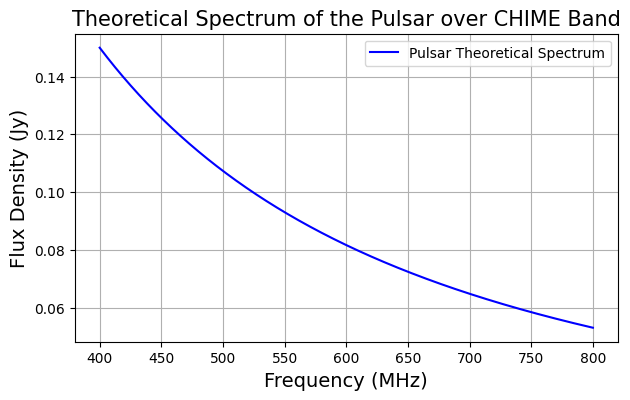

In [4]:
#Flux params of our calibrator source
alpha = -1.5
S400 = 0.15

#array of CHIME frequencies
#We go from 800 -> 400 to construct a theoretical flux array that is indexed
# in the same way. This way our theoretical flux array matches the indexing
# of the measured data set that has the frequencies in a decending order.
chime_freqs = np.linspace(400, 800, 1024)

#Calculate the theoretical flux at ehach frequency
flux_theory = theoretical_spectrum(chime_freqs, alpha, S400)

#Plot the theoretical spectrum
plt.figure(figsize=(7, 4))
plt.plot(chime_freqs, flux_theory, label='Pulsar Theoretical Spectrum', color='blue')
plt.xlabel('Frequency (MHz)', fontsize=14)
plt.ylabel('Flux Density (Jy)', fontsize=14)
plt.title('Theoretical Spectrum of the Pulsar over CHIME Band', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

Let's load in the Numpy array representing the average blank sky spectrum from the previous part of the project and make a plot to recall what we're working with.

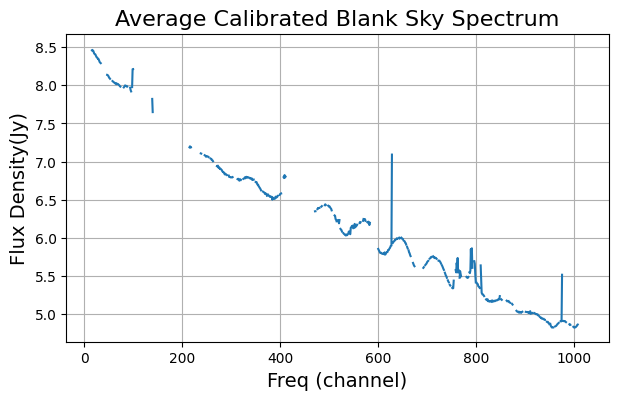

In [5]:
avg_blank_sky_spectrum = np.load('avg_blank_sky_spectrum.npy')

#Plotting average spectrum
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(avg_blank_sky_spectrum)
ax.set_title('Average Calibrated Blank Sky Spectrum', fontsize = 16)
ax.set_xlabel('Freq (channel)', fontsize = 14)
ax.set_ylabel('Flux Density(Jy)', fontsize = 14)
ax.grid(True)
plt.show()

### Finding S/N for 1 Pulse

Defing a function to quickly calculate the S/N given a certain number of integrations, $N$..

Then the only piece we're missing for this part of the question is the number of integrations. Since we only want the S/N for a single pulse, this is equivelant to integrating a single time over the data set, so we set $N=1$.

In [6]:
#defining the S/N function
def signal_to_noise(S_nu, S_sys, N):
    """
    Calculates the signal to expected signal to noise given the source flux
    density and a measure of the system equivalent flux density

    Params
    ------
    S_nu
        The source flux density
    S_sys
        The system equivalent flux density
    N
        Total number of samples being integrated

    Returns
    -------
    (S/N)
        The expected signal to noise ratio given the parameters provided
    """
    return (S_nu/S_sys) * np.sqrt(N)

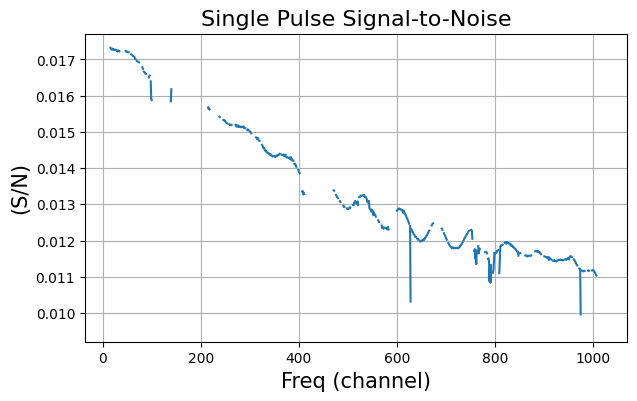

In [7]:
#using the function above, calculate the expected signal to noise
S_nu = flux_theory
S_sys = avg_blank_sky_spectrum
N_single_pulse = 1   #single integration
S_to_N_1_pulse = signal_to_noise(S_nu, S_sys, N_single_pulse)

#Plot out the expected signal to noise as a function of frequency
fig, ax = plt.subplots(figsize = (7, 4))
# ax.plot(S_to_N_1_pulse)
ax.plot(np.where(S_to_N_1_pulse == 0, np.nan, S_to_N_1_pulse))
ax.set_title('Single Pulse Signal-to-Noise', fontsize = 16)
ax.set_xlabel('Freq (channel)', fontsize = 15)
ax.set_ylabel('(S/N)', fontsize = 15)
ax.grid(True)
plt.show()

### $N$ for S/N of ~ 2

To find the expected number of integrations (ie. $N$), we can use scipy.optimize to solve for the roots when (S/N) = 2.

At this point, there are a number of ways we could derive a value of $N$ that corresponds to a (S/N) = 2, since both $S_{\nu}$ and $S_{sys}$ are arrays spanning across all of the frequency channels. We can determine a value for the number of folds desired to create a signal-to-noise ratio of 2 for each of the following:

1. Averaging the (S/N) across all frequency channels
2. The worst (S/N) channel
3. A value of $N$ for each of the frequency channels

N for each of these scenarios provides slightly different information that may individually come in handy when determining what is required to produce the desired signal-to-noise given exposure time.

The frequency-averaged S/N for 1 pulse is 0.009994
The number of integrations required to achieve S/N ~2 for frequency-avged S/N is 40048.605007

Worst_SN_channel is 1020. The associated S/N is 0.009596.
The number of integrations required to achieve S/N ~2 for the worst S/N channel is 43442.205092

The number of integrations to achieve S/N ~ 2 for each of the different frequency channels can be seen in the plot below:


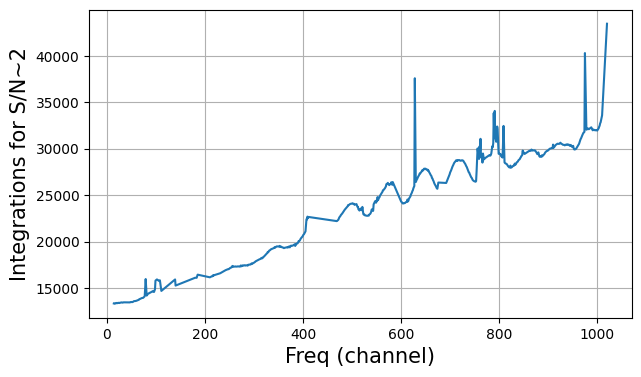

In [8]:
#beginning with finding N for average S/N
#----------------------------------------

#avg S/N for one pulse
S_N_avg = np.nanmean(signal_to_noise(S_nu, S_sys, 1))
print(f"The frequency-averaged S/N for 1 pulse is {S_N_avg:.6f}")

#Compute desired N to observe S/N of ~2
N_2_freq_avg = 4*(1/S_N_avg**2)
print(f"The number of integrations required to achieve S/N ~2 for frequency-avged S/N is {N_2_freq_avg:.6f}")

#N for the worst S/N channel
#---------------------
print()

#computing worst S/N channel
#first filter out 0 and nan entries in array
zero_nan_mask = (S_to_N_1_pulse != 0) & (~np.isnan(S_to_N_1_pulse))
# print(zero_nan_mask)
S_to_N_1_pulse_nonzero = np.array(S_to_N_1_pulse[zero_nan_mask])

worst_SN_channel = np.argmin(S_to_N_1_pulse_nonzero)
worst_SN = S_to_N_1_pulse_nonzero[worst_SN_channel]

#keeping track of the worst channal in terms of original frequencies
valid_inds = np.arange(len(S_to_N_1_pulse))[zero_nan_mask]
original_worst_index = valid_inds[worst_SN_channel]
print(f"Worst_SN_channel is {original_worst_index}. The associated S/N is {worst_SN:.6f}.")

#Compute desired N to observe S/N of ~2
N_2_worst_channel = 4*(1/worst_SN**2)
print(f"The number of integrations required to achieve S/N ~2 for the worst S/N channel is {N_2_worst_channel:.6f}")


#N for every channel (this is essentially the previous step but with N calculated for all channels, not just the worst)
#---------------------
print()

#compute desired N to observe S/N of ~2 over the whole S/n single pulse array
N_2_whole_array = 4*(1/S_to_N_1_pulse_nonzero**2)

#easiest to just plot the above array to visualise the different N values
print("The number of integrations to achieve S/N ~ 2 for each of the different frequency channels can be "
      "seen in the plot below:")
fig, ax = plt.subplots(figsize = (7, 4))
# ax.plot(S_to_N_1_pulse)
ax.plot(valid_inds, N_2_whole_array)
ax.set_xlabel('Freq (channel)', fontsize = 15)
ax.set_ylabel('Integrations for S/N~2', fontsize = 15)
ax.grid(True)
plt.show()

So at the best S/N frequency channel (this seems to be at much lower frequencies) the total number of integrations is close to N=15000, while for the frequency averaged data and especially considering the channel with the worst S/N, the total number of integrations requires for S/N~2 is much closer to 40000. This indicates that a value closer to 40000 folds may be required to observe the pulsar signal if it has sufficiently low signal to noise.

## Part 2: Loading the Pulsar Data

We can begin by taking a look at the header file and then making a quick waterfall plot to see initially what the data looks like.

In [9]:
pulsar_Fil = FilReader('../data/pulsardata.fil')
Pretty(pulsar_Fil.header)

Header(
    filename='../data/pulsardata.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30517,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='../data/pulsardata.fil',
                hdrlen=414,
                datalen=124997632,
                nsamples=30517,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

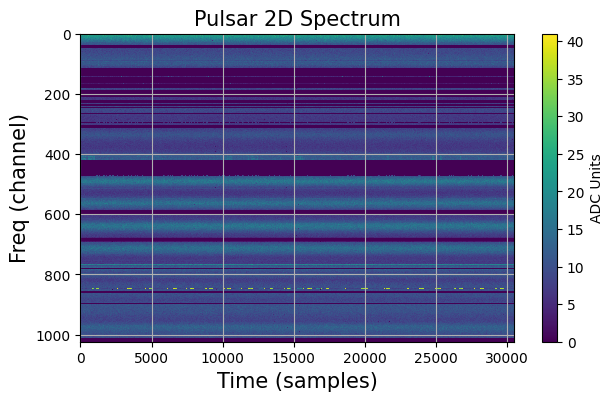

In [10]:
#create the pulsar data object
pulsar_data = pulsar_Fil.read_block(0,
                                    pulsar_Fil.header.nsamples,
                                    pulsar_Fil.header.fch1,
                                    pulsar_Fil.header.nchans
                                    )
pulsar_data_arr = pulsar_data.data

#make a quick waterfall plot of the pulsar data to see what we're working with
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(pulsar_data.data, aspect='auto', interpolation = 'nearest')
ax.set_title('Pulsar 2D Spectrum', fontsize = 15)
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.grid(True)
plt.colorbar(im, label = 'ADC Units')
plt.show()

The initial waterfall plot of the pulsar data reveals many frequency channels dominated by RFI and some patterns across time samples that are difficult to discern. At this stage there are no obvious signs of pulses across the time samples that could be indicative of an observed pulsar.

We can begin by flagging the pulsar data for RFI and get a plot of the S/N.

In [11]:
#flagging rfi using the filterbank built-in function
_, chan_mask = pulsar_Fil.clean_rfi(method="mad", threshold=3)
pulsar_Fil_masked = FilReader('pulsardata_masked.fil')

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Plotting rfi-flagged pulsar data

Similar to part 1, we can plot the flagged data on top of the original average spectrum to get a sense for the channels that have been removed.

In [12]:
pulsar_Fil.compute_stats()

In [13]:
pulsar_Fil_masked.compute_stats()

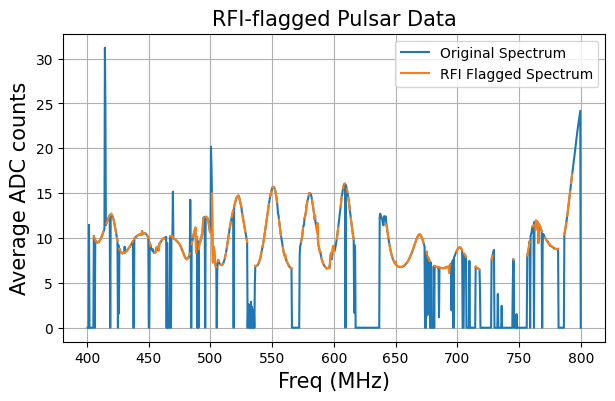

In [14]:
freq_mask = pulsar_Fil_masked.chan_stats.mean == 0
fig, ax = plt.subplots(figsize = (7, 4))
ax.set_title('RFI-flagged Pulsar Data', fontsize = 15)
ax.plot(pulsar_Fil_masked.header.chan_freqs,
        pulsar_Fil.chan_stats.mean,
        label = 'Original Spectrum',
        )
ax.plot(pulsar_Fil_masked.header.chan_freqs,
        np.where(~freq_mask, pulsar_Fil_masked.chan_stats.mean, np.nan),
        label = 'RFI Flagged Spectrum', 
        )
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Average ADC counts', fontsize = 15)
ax.legend()
ax.grid(True)
plt.show()

We can also make a quick waterfall plot of the rfi-flagged data to compare to above.

In [15]:
#read in the masked pulsar data converting it to an actual array
pulsar_masked_data = pulsar_Fil_masked.read_block(0,
                                                  pulsar_Fil_masked.header.nsamples, pulsar_Fil_masked.header.fch1,
                                                  pulsar_Fil_masked.header.nchans
                                                  )

#unnormalized pulsar data loaded in as a numpy array
pulsar_masked_data_array = pulsar_masked_data.data

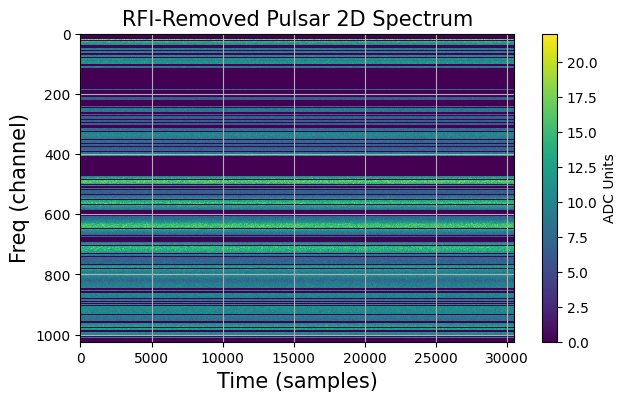

In [16]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(pulsar_masked_data_array, aspect='auto', interpolation = 'nearest')
ax.set_title('RFI-Removed Pulsar 2D Spectrum', fontsize = 15)
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.grid(True)
plt.colorbar(im, label = 'ADC Units')
plt.show()

### Normalizing and Visualizing the Pulsar Data

Since the noise is still quite high, we would eventually like to average across all frequencies to boost the signal strength. To ensure this works, we begin by normalizing the data using Sigpyproc's built-in normalise() method and plotting the 2D spectrum. 

In [17]:
#computing the normalized data and leaving as a filterbank object
norm_pulsar_Fil = pulsar_masked_data.normalise()

#### Water Fall of normalized data

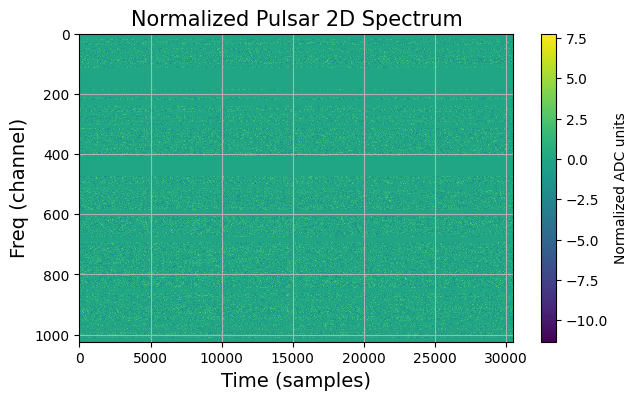

In [18]:
#make a quick waterfall plot of the pulsar data to see what we're working with
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(norm_pulsar_Fil.data, aspect='auto', interpolation = 'nearest')
ax.set_title('Normalized Pulsar 2D Spectrum', fontsize=15)
ax.set_ylabel('Freq (channel)', fontsize = 14)
ax.set_xlabel('Time (samples)', fontsize = 14)
ax.grid(True)
plt.colorbar(im, label='Normalized ADC units')
plt.show()

At this point, there are still no major discernable pulsar features, with the only prominent characteristics of the data being major RFI channels that are still visible. 

### Downsampling and Visualizing Again

Since there aren't any obvious signs of a pulsar signal present in the waterfall plot shown above, we can downsample to try and boost the signal to noise.

To downsample, we need to begin with the FilReader instance and then normalize once again.

Testing out with different amounts of downsampling..

In [19]:
#downsampling -> creates a new file that I load in below
pulsar_Fil_masked.downsample(tfactor=32)
pulsar_Fil_masked.downsample(tfactor=128)
pulsar_Fil_masked.downsample(tfactor=150)

'pulsardata_masked_f1_t150.fil'

In [20]:
#create the FilReader object
pulsar_Fil_masked_32 = FilReader('pulsardata_masked_f1_t32.fil')
pulsar_Fil_masked_128 = FilReader('pulsardata_masked_f1_t128.fil')
pulsar_Fil_masked_150 = FilReader('pulsardata_masked_f1_t150.fil')


#need to read in again in order to normalize and creat the waterfall plot
#read in the masked pulsar data converting it to an actual array
pulsar_masked_32_data = pulsar_Fil_masked_32.read_block(0,
                                            pulsar_Fil_masked_32.header.nsamples, 
                                            pulsar_Fil_masked_32.header.fch1,
                                            pulsar_Fil_masked_32.header.nchans
                                                  )
norm_pulsar_Fil_32 = pulsar_masked_32_data.normalise()

#loading in the different downsampled data
pulsar_masked_128_data = pulsar_Fil_masked_128.read_block(0,
                                            pulsar_Fil_masked_128.header.nsamples, 
                                            pulsar_Fil_masked_128.header.fch1,
                                            pulsar_Fil_masked_128.header.nchans
                                                  )
norm_pulsar_Fil_128 = pulsar_masked_128_data.normalise()

#loading in the different downsampled data
pulsar_masked_150_data = pulsar_Fil_masked_150.read_block(0,
                                            pulsar_Fil_masked_150.header.nsamples, 
                                            pulsar_Fil_masked_150.header.fch1,
                                            pulsar_Fil_masked_150.header.nchans
                                                  )
norm_pulsar_Fil_150 = pulsar_masked_150_data.normalise()


It seems that using tfactor = 32 provides a sufficient level of downsampling to view the smeared out pulses, so this will be the data that is used throughout the rest of the analysis to search for the pulse signal.

We can make a waterfall plot now using the downsampled data set to visualize the pulses.

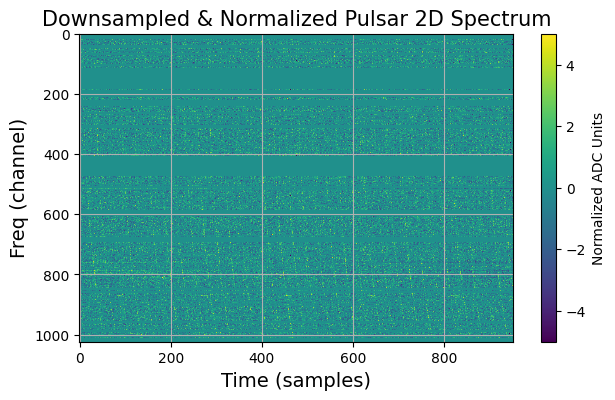

In [21]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(norm_pulsar_Fil_32.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_128.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_150.data, aspect='auto', interpolation = 'nearest')
ax.set_title('Downsampled & Normalized Pulsar 2D Spectrum', fontsize = 15)
ax.set_ylabel('Freq (channel)', fontsize = 14)
ax.set_xlabel('Time (samples)', fontsize = 14)
ax.grid(True)
cb = plt.colorbar(im, label = 'Normalized ADC Units')
im.set_clim(-5, 5)
plt.show()

Zooming in a bit to better see the pulses.

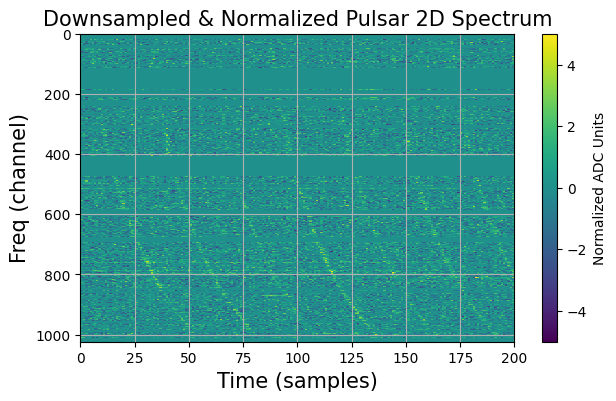

In [22]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(norm_pulsar_Fil_32.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_128.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_150.data, aspect='auto', interpolation = 'nearest')
ax.set_title('Downsampled & Normalized Pulsar 2D Spectrum', fontsize = 15)
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.set_xlim(0, 200)
ax.grid(True)
cb = plt.colorbar(im, label = 'Normalized ADC Units')
im.set_clim(-5, 5)
plt.show()

Ok, great so now we can see the pulses in some detail after downsampling and normalizing. Moreover, we can begin to get a sense for the pulsar's period by examining the header of the normalized filterbank file (cell below). Looking at the header info, we can see that tsamp ~ 0.01, meaning that pulses spaced roughly 25 time samples apart in the tfactor = 32 downsampled data (like we can see above) should have a period of roughly $T = 0.01 \times 25 = 0.25$ seconds. This provides a good estimate for what we plan to look for in the later stages of the project.

In [23]:
Pretty(norm_pulsar_Fil_32.header)

Header(
    filename='pulsardata_masked_f1_t32.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.01048576,
    tstart=np.float64(60638.34381999473),
    nsamples=953,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info={
        'entries': [
            {
                'filename': 'pulsardata_masked_f1_t32.fil',
                'hdrlen': 414,
                'datalen': 3903488,
                'nsamples': 953,
                'tstart': 60638.34381999473,
                'tsamp': 0.01048576
            }
        ]
    }
)

## Part 3: Pulsar S/N as a Function of DM and Time

The eventual goal will be to average over frequency to boost S/N and more easily search for the pulsar. To get to that point, we first need to find the dispersion measure (DM) and frequency were the S/N is the highest. We therefore need to plot the current pulsar data S/N as a function of DM and time so we can begin searching in parameter space for where in the data the S/N is highest.

We can note that to define a central DM to search over, most galactic pulsars have DM values of less than 60. Furthermore, we could use the equation:

$$\tau(f, DM) = k_{DM} DM \left(\frac{1}{f^2} - \frac{1}{f_{ref}^2} \right),$$

to solve for the minimum DM step size to feed to the dmt_transform function. However, using a total number of steps of 1000 provides a sufficient result where the bow-tie features are easily distinguishable and does so in a reasonable runtime.


In [24]:
#creating a grid of DMs and time values to search over
central_dm = 30 #Reasonable midpoint of galactic DMs
dmsteps = 1000 
SN_DM_t = norm_pulsar_Fil_32.dmt_transform(central_dm, dmsteps=dmsteps)

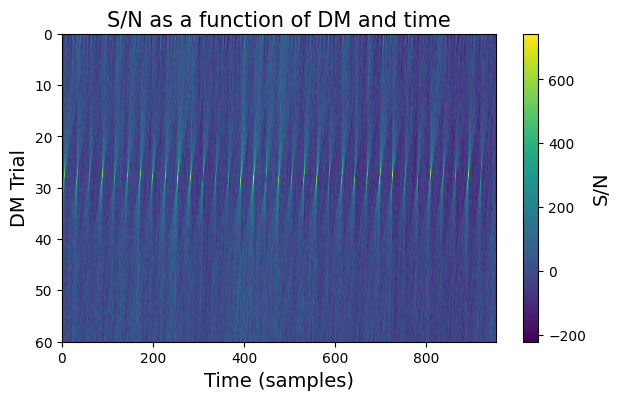

In [25]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(SN_DM_t.data, aspect='auto', interpolation = 'nearest', 
               extent=[0, SN_DM_t.data.shape[1],  SN_DM_t.dms[-1], SN_DM_t.dms[0]])
ax.set_title('S/N as a function of DM and time', fontsize = 15)
ax.set_ylabel('DM Trial', fontsize = 14)
ax.set_xlabel('Time (samples)', fontsize = 14)
# ax.set_yticks([SN_DM_t.dms])
cb = plt.colorbar(im)
cb.set_label('S/N', fontsize=14) 
plt.show()

So we can clearly see that the majority of the power per pulse is aligned at a single DM across all of the time samples and appears periodic in time as expected for a pulsar signal. 

We can also zoom in a bit to get a better view of the bow-tie pattern. Furthermore, we can see this occurs for a DM of roughly 28 pc $\text{cm}^{-3}$

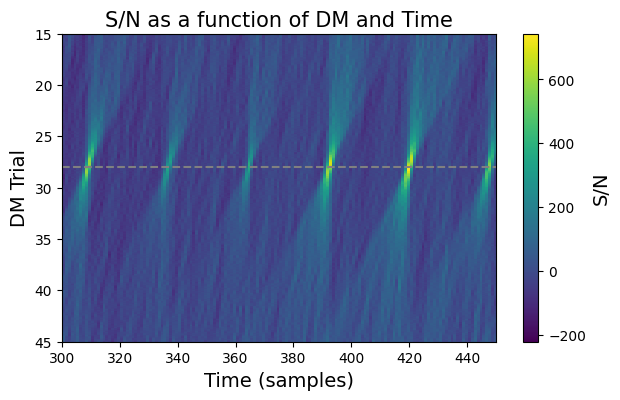

In [26]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(SN_DM_t.data, aspect='auto', interpolation = 'nearest', 
               extent=[0, SN_DM_t.data.shape[1],  
                       SN_DM_t.dms[-1], SN_DM_t.dms[0]])
ax.set_title('S/N as a function of DM and Time', fontsize = 15)
ax.set_ylabel('DM Trial', fontsize = 14)
ax.set_xlabel('Time (samples)', fontsize = 14)
ax.set_xlim(300, 450)
ax.set_ylim(45, 15)
ax.axhline(y = 28, color = 'grey', linestyle = '--')
cb = plt.colorbar(im)
cb.set_label('S/N', fontsize=14) 
plt.show()

## Part 4: FT of S/N(DM, t)

We'll do the search for the periodic signal in frequency space, meaning we need to take a Fourier transform of the previous S/N(DM, t) function above. Using Numpy to take the fft and plotting the 2D spectrum, we can see the DM once again localized to a strip of DMs with most of the power constrained now to certain frequency bins.

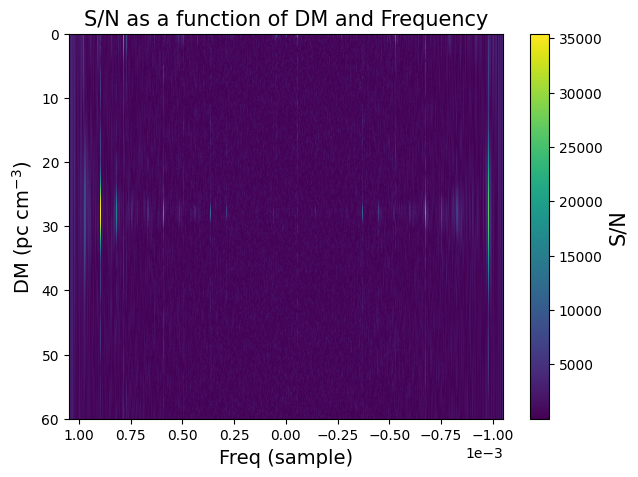

In [27]:
#calculate the FT and the associated frequency bins
SN_DM_FT = np.fft.fft(SN_DM_t.data, axis = 1)

#calculate the range of values to use as frequencies
#---------------------------------------------------------------------
# note that n_tsamples is in units of sample number, so the resulting 
# frequencies will have units of 1/(sample number)
#---------------------------------------------------------------------
n_tsamples = SN_DM_t.data.shape[1]
# print(n_tsamples)
SN_DM_freqs = np.fft.fftfreq(int(n_tsamples))
# print(SN_data_freqs)

#plot the S/N(DM, freq) data
fig, ax = plt.subplots(figsize = (7, 5))
ax.set_title('S/N as a function of DM and Frequency', fontsize = 15)
im = ax.imshow(np.abs(SN_DM_FT), aspect='auto', interpolation = 'nearest',
               extent=[SN_DM_freqs[1], SN_DM_freqs[-1],  
                       SN_DM_t.dms[-1], SN_DM_t.dms[0]])
ax.set_ylabel('DM (pc cm$^{-3}$)', fontsize = 14)
# ax.set_xlabel('Freq (1/$t_{sample}$)', fontsize = 14)
ax.set_xlabel('Freq (sample)', fontsize = 14)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# ax.grid(True)
cb = plt.colorbar(im, label = 'S/N')
cb.set_label('S/N', fontsize = '15')
plt.show()

### Finding DM and Frequency maximizing S/N

To find the value of DM and frequncy to search for the pulsar at, we need to look in the above S/N(DM, $\nu$) space for the corresponding set of DM and $\nu$ values that maximize the S/N. 

In [28]:
#find the arg max of the unraveled S/N(DM, freq) array
max_ind = np.argmax(abs(SN_DM_FT))

#use the above index to find the corresponding DM (row index) and freq (col index) indices
max_dm_ind, max_freq_ind = np.unravel_index(max_ind, SN_DM_FT.shape)

print(f"The index location of the max DM value is {max_dm_ind}\n" 
      f" and corresponds to a DM value of {SN_DM_t.dms[max_dm_ind]:.4f} pc cm^-3")


print()
print(f"The index location of the max fequency value is {max_freq_ind}\n" 
      f" and corresponds to a frequency value of {SN_DM_freqs[max_freq_ind]:.6f} in units of 1/tsamples")

The index location of the max DM value is 462
 and corresponds to a DM value of 27.7477 pc cm^-3

The index location of the max fequency value is 69
 and corresponds to a frequency value of 0.072403 in units of 1/tsamples


## Part 5: Folding the Data

Now that we know the DM and frequency values of the pulse, we can use the built-in method, fold(), in sigpyproc to fold the data into 1024 channels and a single pulse.

In [29]:
#First find the max frequency value
max_freq = SN_DM_freqs[max_freq_ind]

#convert back to units of time samples (ie. calculate the period)
period = 1/max_freq 

#convert to units of time (factor of 2 comes from the symmetry of the FT) 
period = SN_DM_t.header.tsamp*period*2 

#retrieve max DM
dm = SN_DM_t.dms[max_dm_ind]

#fold the data into 1024 channels and one pulse
pulsar_Fil_masked_32_folded = pulsar_Fil_masked_32.fold(
    period=period,
    dm=dm,
    nints=1,
    nbands=1024,
    nbins=int(period//pulsar_Fil_masked_32.header.tsamp)
)

Check what the waterfall plot looks like at this stage.

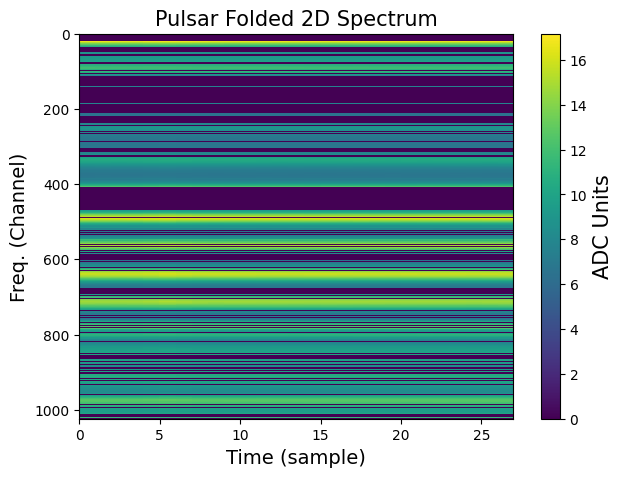

In [30]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.set_title('Pulsar Folded 2D Spectrum', fontsize = 15)
im = ax.imshow(pulsar_Fil_masked_32_folded.data[0,:,:], aspect='auto', interpolation = 'nearest',
               extent=[0, pulsar_Fil_masked_32_folded.data.shape[2],  
                       pulsar_Fil_masked_32_folded.header.nchans, 0])
# im = ax.imshow(pulsar_Fil_masked_32_folded, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('Freq. (Channel)', fontsize = 14)
# ax.set_xlabel('Freq (1/$t_{sample}$)', fontsize = 14)
ax.set_xlabel('Time (sample)', fontsize = 14)
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# ax.grid(True)
cb = plt.colorbar(im, label = 'S/N')
cb.set_label('ADC Units', fontsize = '15')
plt.show()

### Frequency Averaged Pulse Profile

Finally, we can take the mean across frequencies to view the pulse after folding the original data set.

In [31]:
#define a set of time values for a single period to plot over
t_final = pulsar_Fil_masked_32_folded.header.tsamp*pulsar_Fil_masked_32_folded.data.shape[2]
tvals = np.arange(0, t_final, pulsar_Fil_masked_32_folded.header.tsamp)

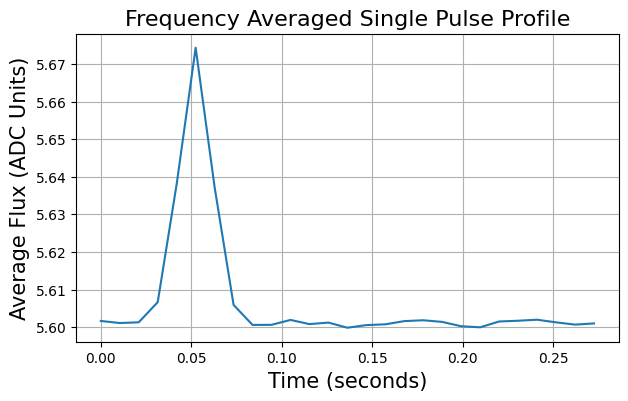

In [32]:
#calculate and plot the mean profile
pulse_profile = np.mean(pulsar_Fil_masked_32_folded.data[0,:,:], axis = 0)

fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(tvals, pulse_profile)
ax.set_title('Frequency Averaged Single Pulse Profile', fontsize = 16)
ax.set_xlabel('Time (seconds)', fontsize = 15)
ax.set_ylabel('Average Flux (ADC Units)', fontsize = 15)
ax.grid(True)
plt.show()

So by folding the data into 1024 channels we can thereby boost the S/N, revealing a clean pulse profile over one single period.

As a final step, we can compute the frequency averaged single pulse profile for the non-downsampled data to increase the resolution in the final result. Repeating the final sequence of steps here..

In [33]:
#fold the data into 1024 channels and one pulse
pulsar_Fil_masked_folded = pulsar_Fil_masked.fold(
    period=period,
    dm=dm,
    nints=1,
    nbands=1024,
    nbins=int(period//pulsar_Fil_masked.header.tsamp)
)

### Frequency Averaged Pulse Profile (non - downsampled)

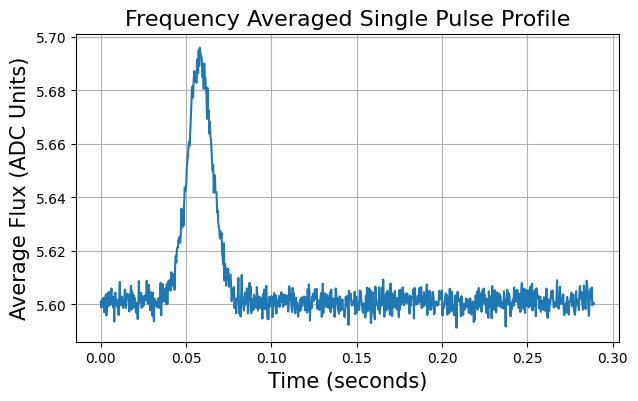

In [34]:
#define a set of time values for a single period to plot over
t_final = pulsar_Fil_masked_folded.header.tsamp*pulsar_Fil_masked_folded.data.shape[2]
tvals = np.arange(0, t_final, pulsar_Fil_masked_folded.header.tsamp)
#calculate and plot the mean profile
pulse_profile = np.mean(pulsar_Fil_masked_folded.data[0,:,:], axis = 0)

fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(tvals, pulse_profile)
ax.set_title('Frequency Averaged Single Pulse Profile', fontsize = 16)
ax.set_xlabel('Time (seconds)', fontsize = 15)
ax.set_ylabel('Average Flux (ADC Units)', fontsize = 15)
ax.grid(True)
plt.show()

Although the resolution is slightly larger, we increase the amount of noise present in the final pulse profile. Nonetheless, the pulse over a single period is still very obvious.